This notebook implement the cubic spiral optimization algorithm described in the McNaughton paper for motion planning (https://www.ri.cmu.edu/pub_files/2011/7/mcnaughton-thesis.pdf). The high level algorithm will connect two poses (x,y, theta, kappa) with a cubic spiral By that, we mean curvature (kappa) is a cubic polynomial function of travel (s).

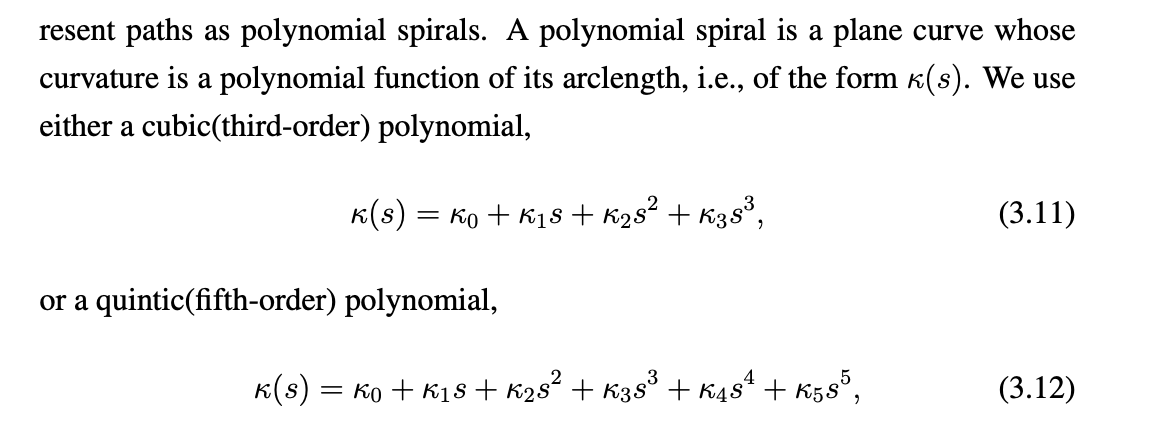

In [1]:
from sympy import *
import numpy

# cubic spline allows for continuous curvature
# 3.3.1 introduces cubic polynominal spirals
# 3.5 talks about stability and introducing new parameters
# 3.6 onward talks about optimization

# a,b,c,d are the coefficients of the cubic polynomial, s is the variable that represents travel along the spiral.
a,b,c,d, s = symbols("a b c d s")


Since kappa 0...3 differ by orders of magnitude, optimizing to find them can cause numerical stability issues. Instead, we reparameterize the spiral with the curvature at points along the curve (p0...p3) and can derive the original cubic coefficients from them.

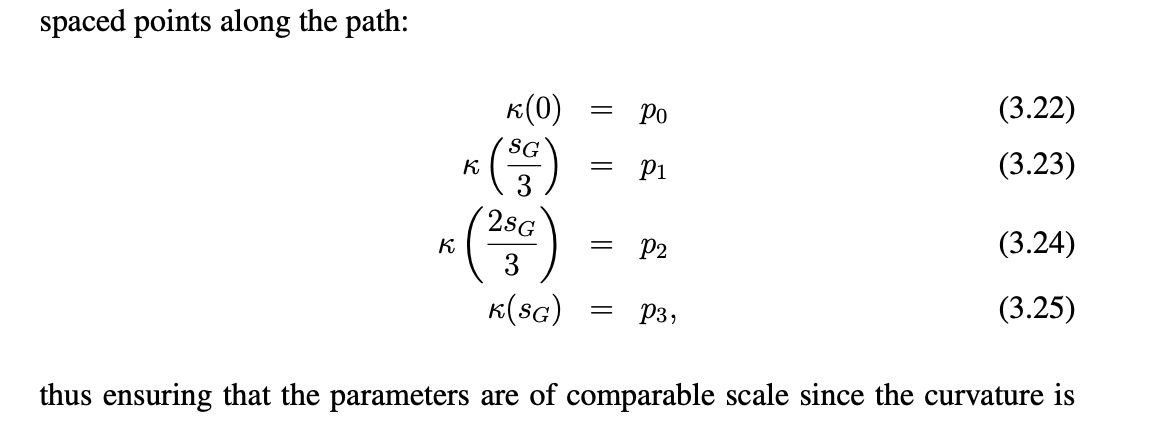
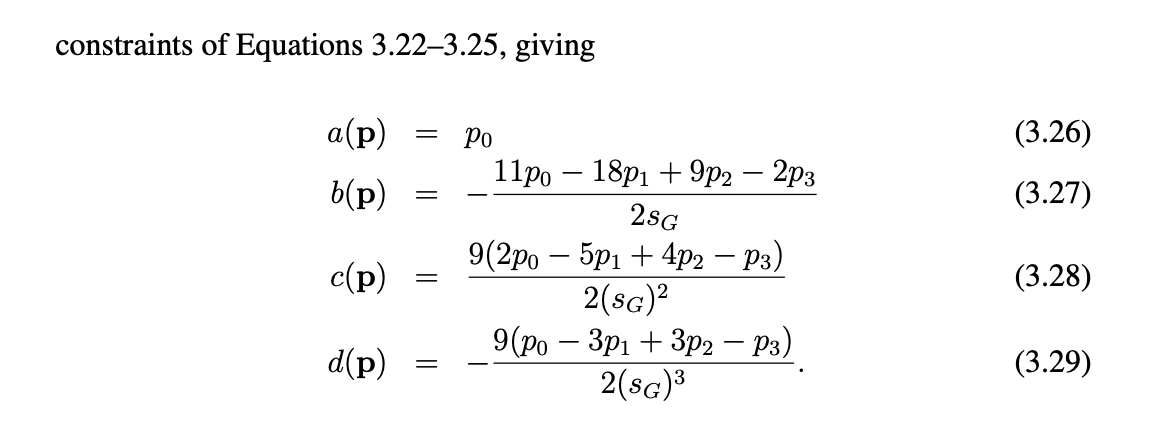

In [2]:
p0, p1, p2, p3, sG = symbols("p0 p1 p2 p3 sG")
kappa = a + b*s + c*s**2 + d*s**3
eq1 = kappa.subs(s,0) - p0
eq2 = kappa.subs(s, sG/3) - p1
eq3 = kappa.subs(s, 2*sG/3) - p2
eq4 = kappa.subs(s, sG) - p3
sol = solve([eq1, eq2, eq3, eq4], {a, b, c, d})

In [3]:
sol # these should match up with the paper

{a: p0,
 b: (-11*p0 + 18*p1 - 9*p2 + 2*p3)/(2*sG),
 c: (18*p0 - 45*p1 + 36*p2 - 9*p3)/(2*sG**2),
 d: (-9*p0 + 27*p1 - 27*p2 + 9*p3)/(2*sG**3)}

In [4]:
a = sol[a]
b = sol[b]
c = sol[c]
d = sol[d]

Now we know we can solve for p0...3 instead of kappa0...3.
Now let's look at how we can use the p parameters to compute the configuration (and not just the curvature) at any travel. As the text states, we can assume our initial position starts at [0,0,0, kappa_I].

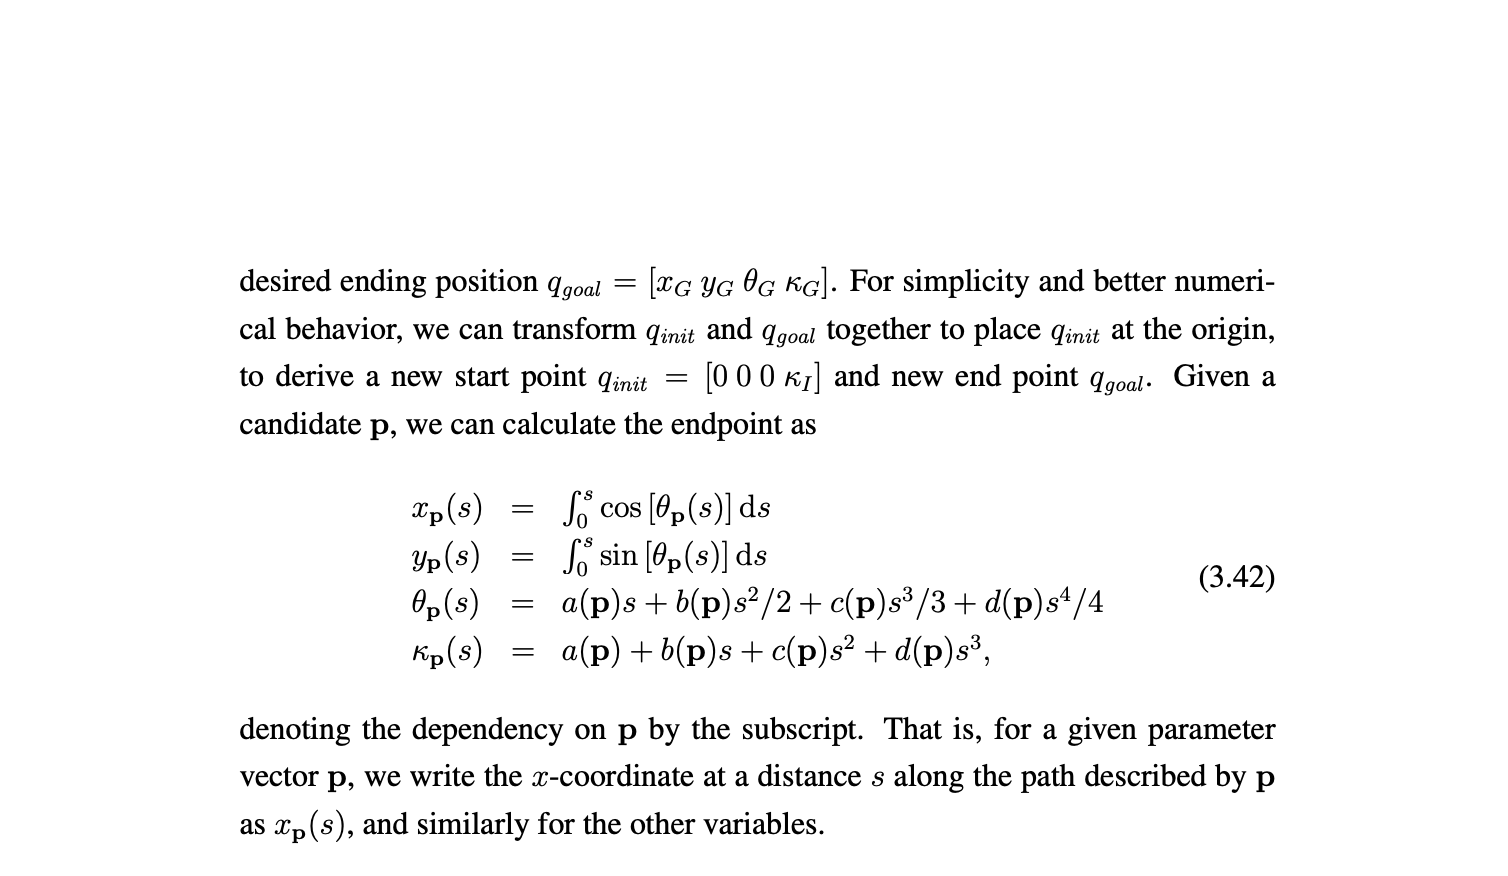




In [13]:
# if a,b,c,d are known, easy to compute theta(s)
theta = a*s + b*s**2/2 + c*s**3/3 + d*s**4/4
kappa = a + b*s + c*s**2 + d*s**3

In [6]:

theta

p0*s + s**4*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/(8*sG**3) + s**3*(18*p0 - 45*p1 + 36*p2 - 9*p3)/(6*sG**2) + s**2*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/(4*sG)

In [7]:
# we can or take deriv of theta wrt diff params (i.e sG or p1)
diff(theta, sG)

-3*s**4*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/(8*sG**4) - s**3*(18*p0 - 45*p1 + 36*p2 - 9*p3)/(3*sG**3) - s**2*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/(4*sG**2)

In [ ]:
# what about x or y?
# x = integrate(cos(theta),(s,0,s)) will crash sympy...

While the heading and curvature are straightforward to compute, the x and y positions do not have a closed form solution. Instead, we use a "composite simpson" rule to integrate numerically.


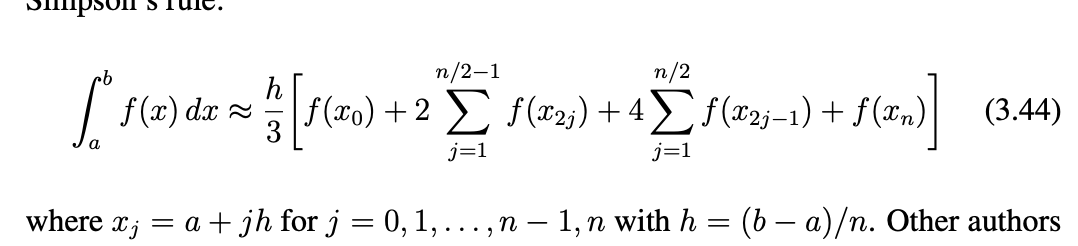

In [8]:

# returns the symbolic derivative of the composite simpson intergral of f (from 0 to sG)
# n is the number of parts to break it into, must be even.
def composite_simpson(f, sG, n=8):
    h = (sG)/n
    
    exp = f.subs(s,0)
    for j in range(1, int(n/2)):
        exp += 2 * f.subs(s,2*j*sG/n)
        
    for j in range(1, int(n/2)+1):
        exp += 4 * (f.subs(s,(2*j-1)*sG/n))
    
    exp += f.subs(s,sG)
        
    exp *= (h/3.0)    
    return exp

Using the composite simpson method, we can now write down x_sG in sympy.

In [9]:

x_sG = composite_simpson(cos(theta), sG)
y_sG = composite_simpson(sin(theta), sG)

In [10]:
x_sG

0.0416666666666667*sG*(4*cos(p0*sG/8 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/3072) + 2*cos(p0*sG/4 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/64 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/2048 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/384) + 4*cos(3*p0*sG/8 + 9*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 81*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 9*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/1024) + 2*cos(p0*sG/2 + sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/16 + sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/128 + sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/48) + 4*cos(5*p0*sG/8 + 25*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 625*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 125*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/3072) + 2*cos(3*p0*sG/4 + 9*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/64 + 81*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/2048 + 9*sG*(18*p0 - 45*p1 + 36*p2 - 9*p3)/128) + 4*cos(7*p0*sG/8 + 49*sG*(-11*p0 + 18*p1 - 9*p2 + 2*p3)/256 + 2401*sG*(-9*p0 + 27*p1 - 27*p2 + 9*p3)/32768 + 343*sG*(1

Now let's double-check our equations look correct. We'll pick a set of parameters and plot some points along the resulting cubic spiral.

In [19]:
# lets say we have some initial guess
p0_g = 0
p1_g = 0.1
p2_g = 0.2
p3_g = 0.3
sG_g = 20

p_g = (p0_g, p1_g, p2_g, p3_g, sG_g)

def eval_guess(s_eval, p_g):
    p0_g = p_g[0]
    p1_g = p_g[1]
    p2_g = p_g[2]
    p3_g = p_g[3]
    sG_g = p_g[4]
    # note that i set s and sG to s_eval for x,y but sG to sG_g for theta.
    # this is not technically correct - this is because i use sG as the argument in composite simpson when it should 
    # really be s_eval. has to do with the way I'm re-using variable names in sympy
    # and i don't understand the correct way to do it.
    x_sG_g = x_sG.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (sG, s_eval)])
    y_sG_g = y_sG.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (sG, s_eval)])
    theta_sG_g = theta.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, sG_g)])
    ka_g = kappa.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, sG_g)])
    return x_sG_g, y_sG_g, theta_sG_g, ka_g

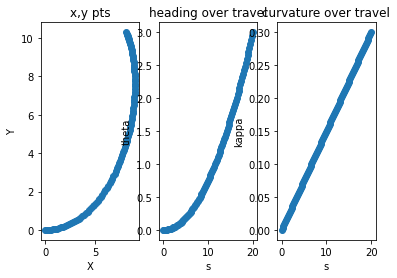

In [22]:
# let's plot it to make sure this looks right-ish?
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot(p_g):
    xs = []
    ys = []
    ths = []
    kas = []
    ss = np.linspace(0, sG_g, 100)
    for s in ss:
        x,y,th,ka = eval_guess(s, p_g)
        xs.append(x)
        ys.append(y)
        ths.append(th)
        kas.append(ka)
            
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.set_title('x,y pts')
    ax1.plot(xs,ys, 'o')
    ax1.set(xlabel='X', ylabel='Y')
    
    ax2.set_title('heading over travel')
    ax2.plot(ss, ths, 'o')
    ax2.set(xlabel='s', ylabel='theta')

    ax3.set_title('curvature over travel')
    ax3.plot(ss, kas, 'o')
    ax3.set(xlabel='s', ylabel='kappa')
    
    plt.show()

plot(p_g)

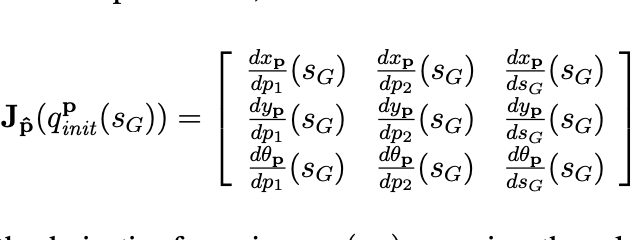

In [ ]:
# J11 = diff(x_sG, p1)
# J12 = diff(x_sG, p2)
# J13 = diff(x_sG, sG)
# J21 = diff(y_sG, p1)
# J22 = diff(y_sG, p2)
# J23 = diff(y_sG, sG)
J11 = composite_simpson(diff(cos(theta), p1), sG)
J12 = composite_simpson(diff(cos(theta), p2), sG)
J13 = composite_simpson(diff(cos(theta), sG), sG)
J21 = composite_simpson(diff(sin(theta), p1), sG)
J22 = composite_simpson(diff(sin(theta), p2), sG)
J23 = composite_simpson(diff(sin(theta), sG), sG)
J31 = diff(theta, p1)
J32 = diff(theta, p2)
J33 = diff(theta, sG)

In [ ]:
J = Matrix([[J11,J12,J13], [J21,J22, J33], [J31,J32,J33]])

In [ ]:
shape(J)

In [ ]:
J

In [ ]:

#s_eval = 20

J_g = J

In [ ]:
J_g

In [ ]:
J_g_inv = J_g.inv()

In [ ]:
J_g_inv

In [ ]:
def eval_guess(s_eval):
    x_sG_g = x_sG.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, s_eval)])
    y_sG_g = y_sG.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, s_eval)])
    theta_sG_g = theta.subs([(p0, p0_g), (p1, p1_g), (p2, p2_g), (p3, p3_g), (s, s_eval), (sG, s_eval)])
    return x_sG_g, y_sG_g, theta_sG_g

In [ ]:
print(eval_guess(1.0))
print(eval_guess(5.0))

In [ ]:
xs